In [12]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, morphology
from cellpose import io
import matplotlib.pyplot as plt
from scipy.ndimage import label
from skimage.measure import regionprops


file_path = "/Users/demir/Documents/Hva_AI/afstudeerproject/E35_tif/20240312_CKR_Exp35_STHdhQ97HA_96h_+BafA_CCT1_635P_HA_580_A11_460L_2.tif"
img = io.imread(file_path) # (9, 4, 1024, 1024)
print(f'img       : {img.shape}')

img_nuclei = img[:, 0, :, :]
img_aggregate = img[:, 2, :, :]
img_cellbody = img[:, 3, :, :]

print(f'Nuclei    : {img_nuclei.shape} \nAggregate : {img_aggregate.shape} \nCell body : {img_cellbody.shape}')

def process_aggregates(img):
    aggregate_masks = []
    for z_slice in range(img.shape[0]):     # img.shape[0] = Z-slices information
        slice_img = img[z_slice, 2, :, :]   # Channel 2 for aggregates
        threshold = 0.55 * np.max(slice_img)
        bright_spots = slice_img > threshold
        clean_mask = morphology.remove_small_objects(bright_spots, min_size=9) # Bu parametrede degistirilebilir olsun.
        aggregate_masks.append(clean_mask)
    return aggregate_masks

aggregate_masks = process_aggregates(img)
aggregate_stack = np.stack(aggregate_masks, axis=0)  # shape: (Z, Y, X)

labeled_aggregates, num_aggregates = label(aggregate_stack)

for i, labeled_slice in enumerate(labeled_aggregates):
    props = regionprops(labeled_slice)
    num_aggregates_z = len(props)  # Agregat sayısı, regionprops ile hesaplanır
    print(f"Z-slice {i+1}: {num_aggregates_z} agg")

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:00<00:00, 559.10it/s]

img       : (8, 4, 1024, 1024)
Nuclei    : (8, 1024, 1024) 
Aggregate : (8, 1024, 1024) 
Cell body : (8, 1024, 1024)
Z-slice 1: 4 agg
Z-slice 2: 5 agg
Z-slice 3: 8 agg
Z-slice 4: 30 agg
Z-slice 5: 49 agg
Z-slice 6: 28 agg
Z-slice 7: 6 agg
Z-slice 8: 6 agg


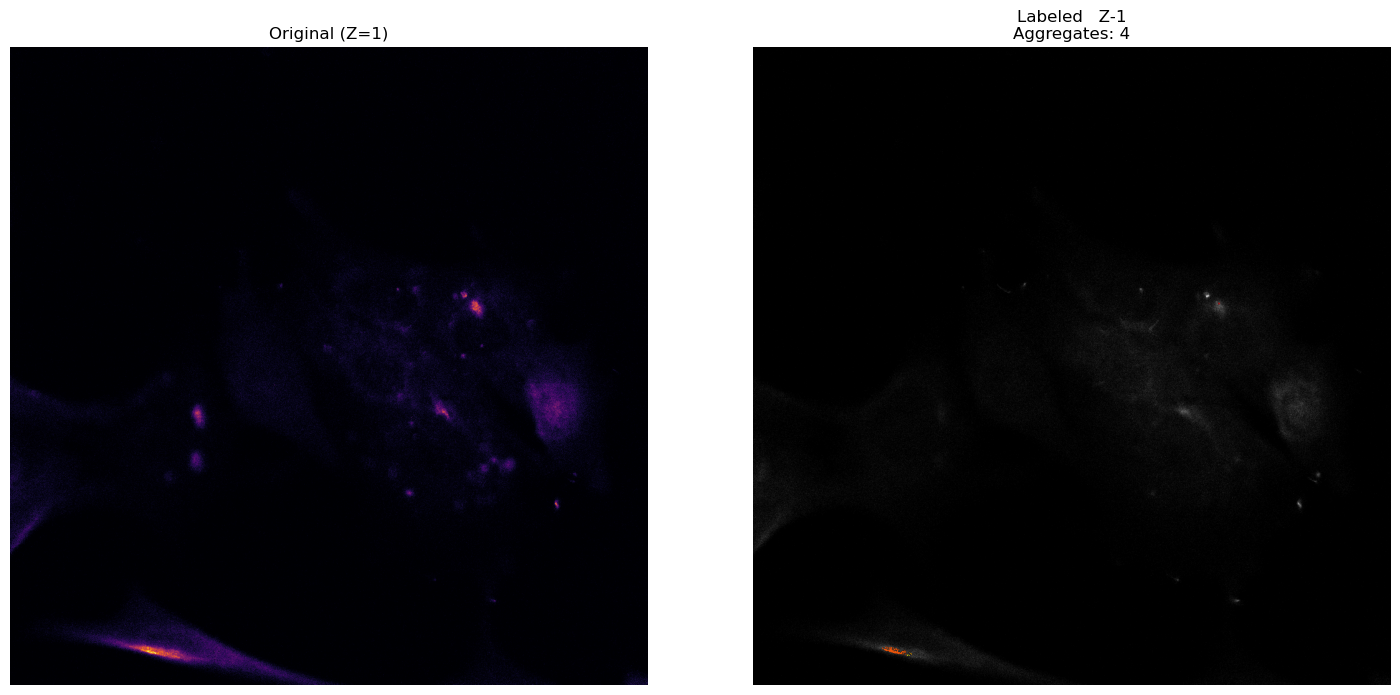

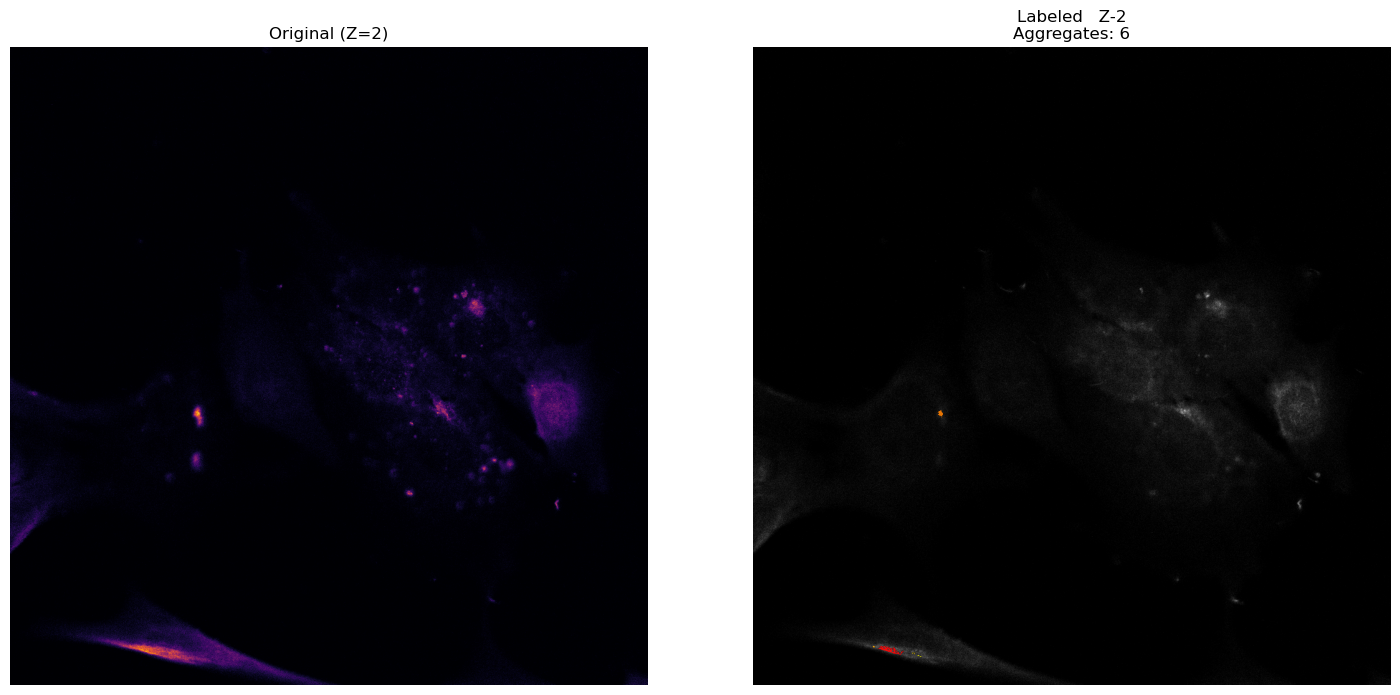

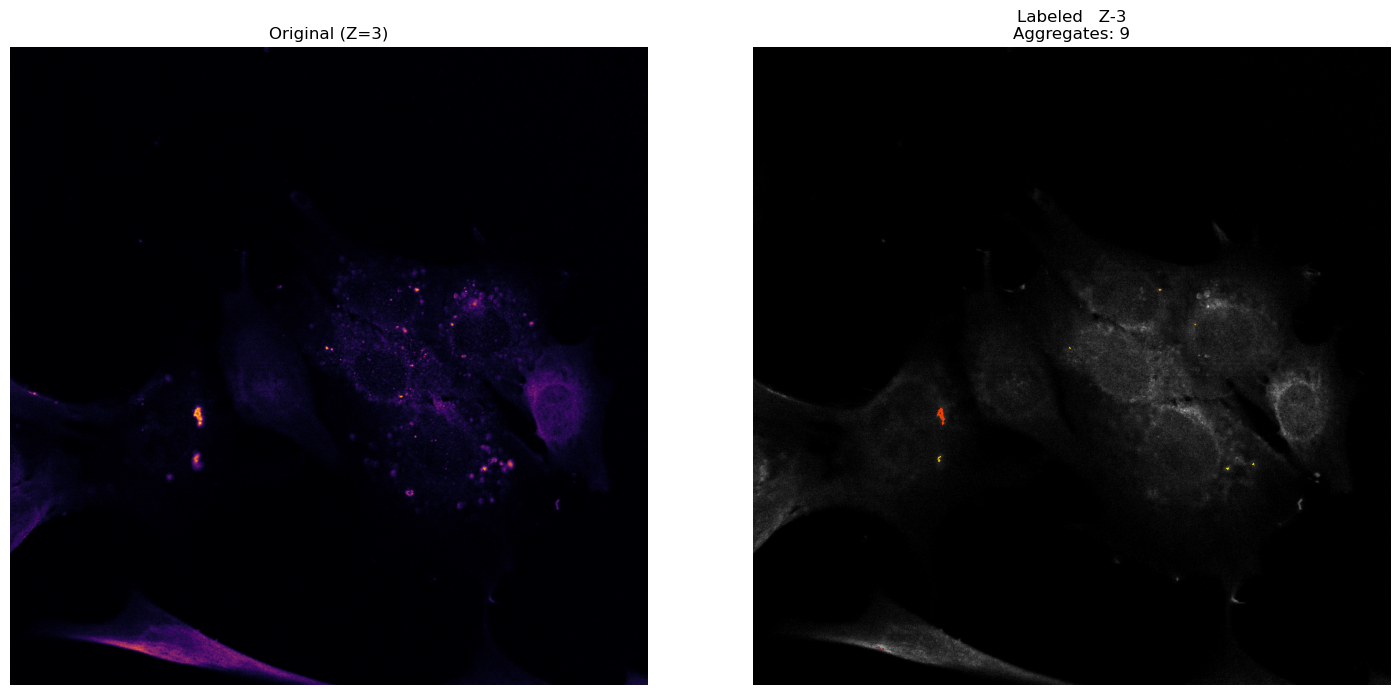

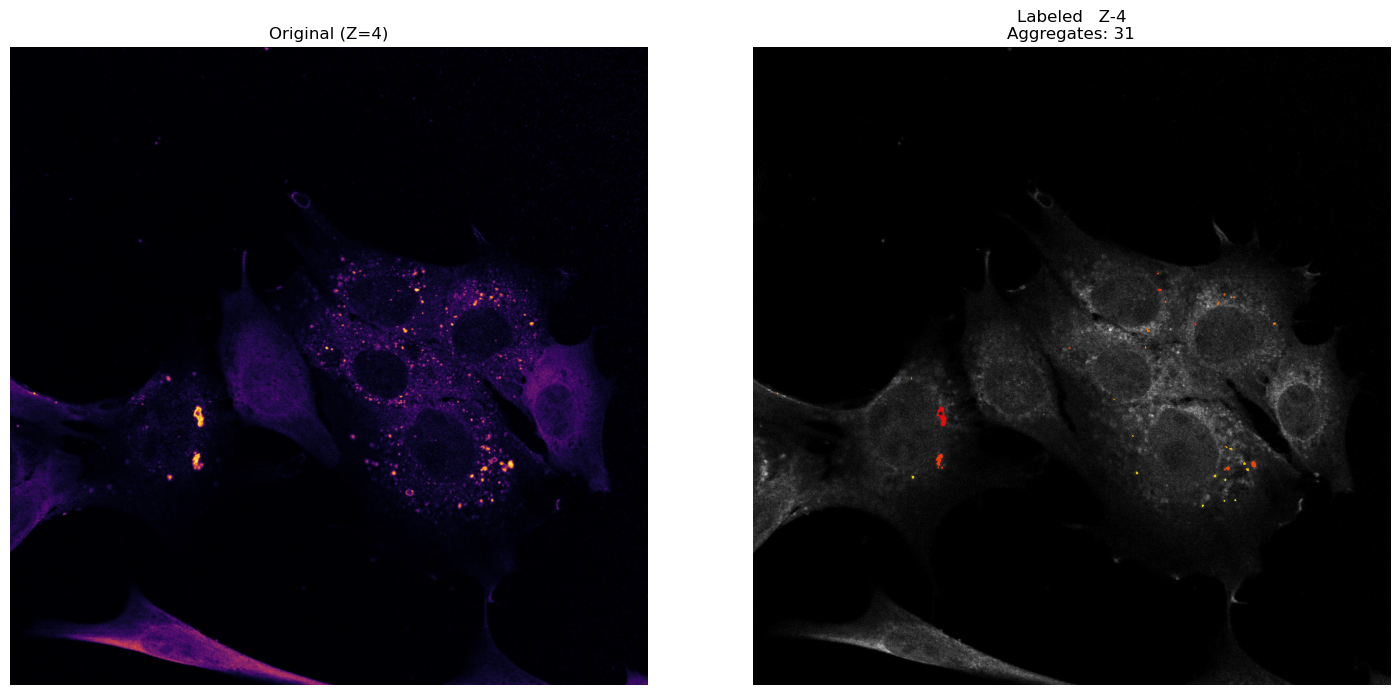

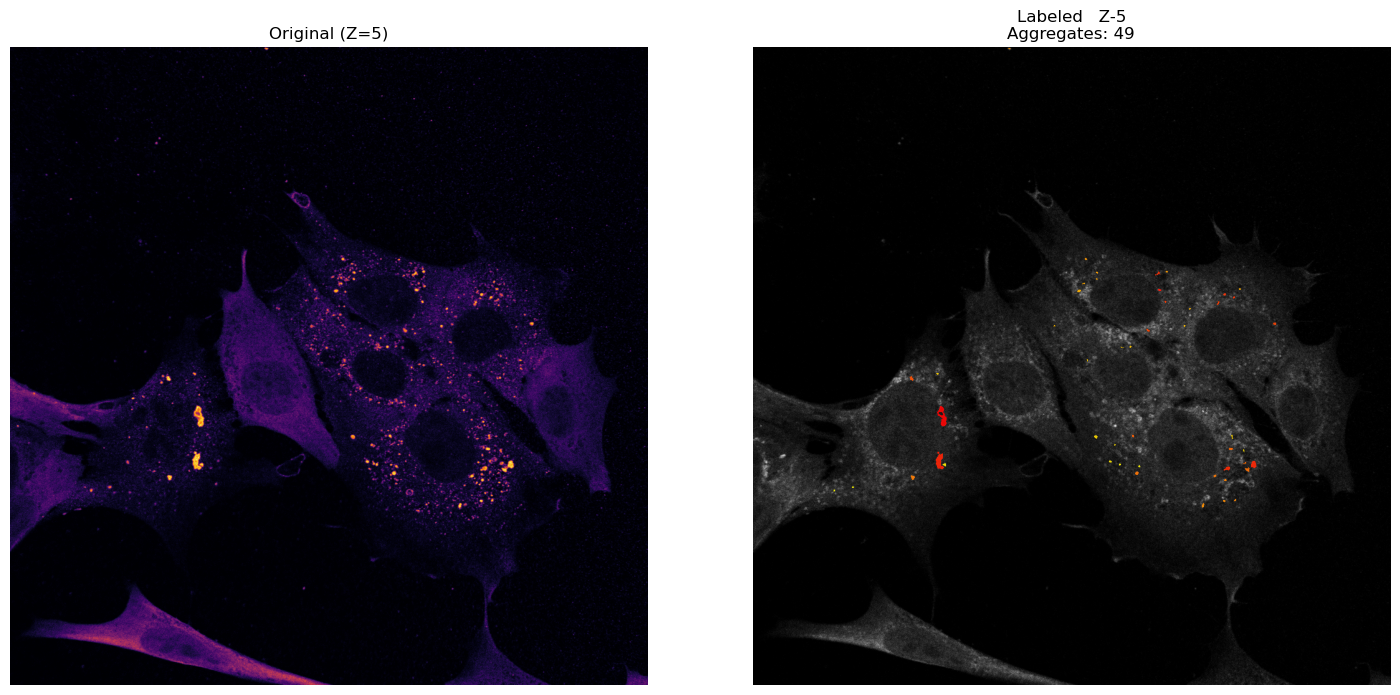

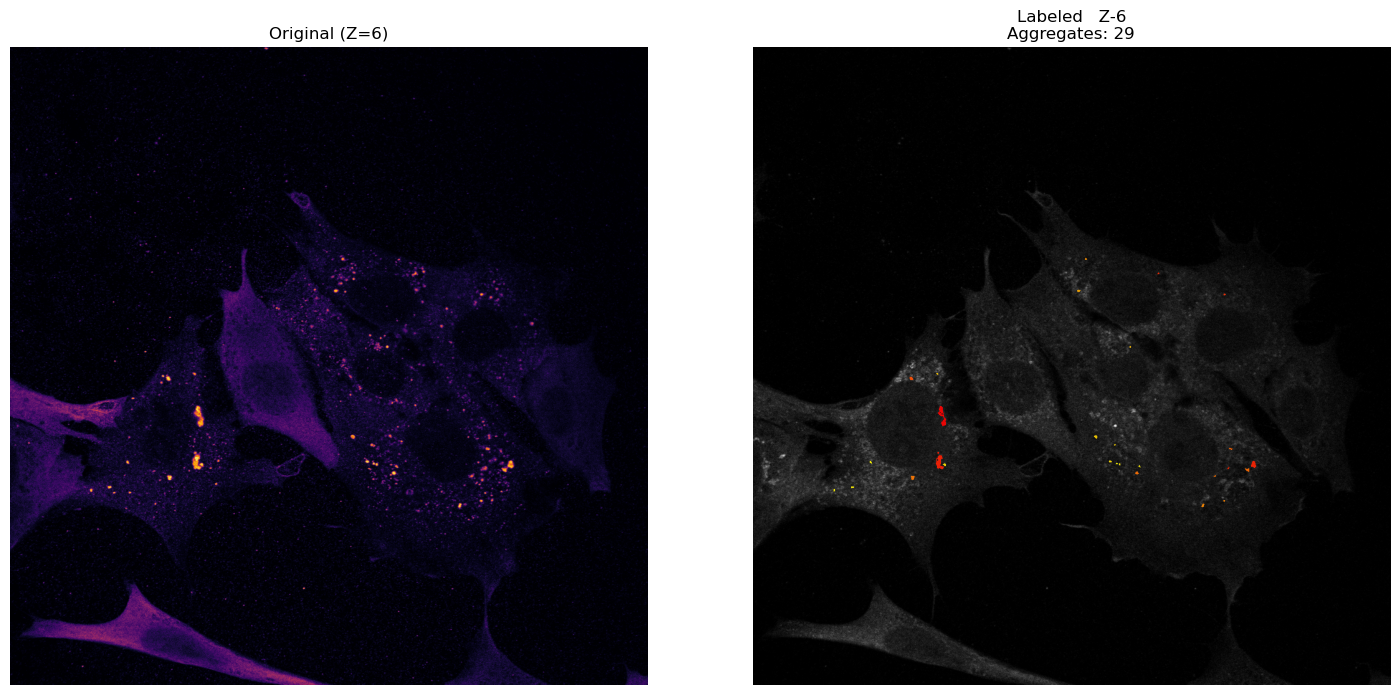

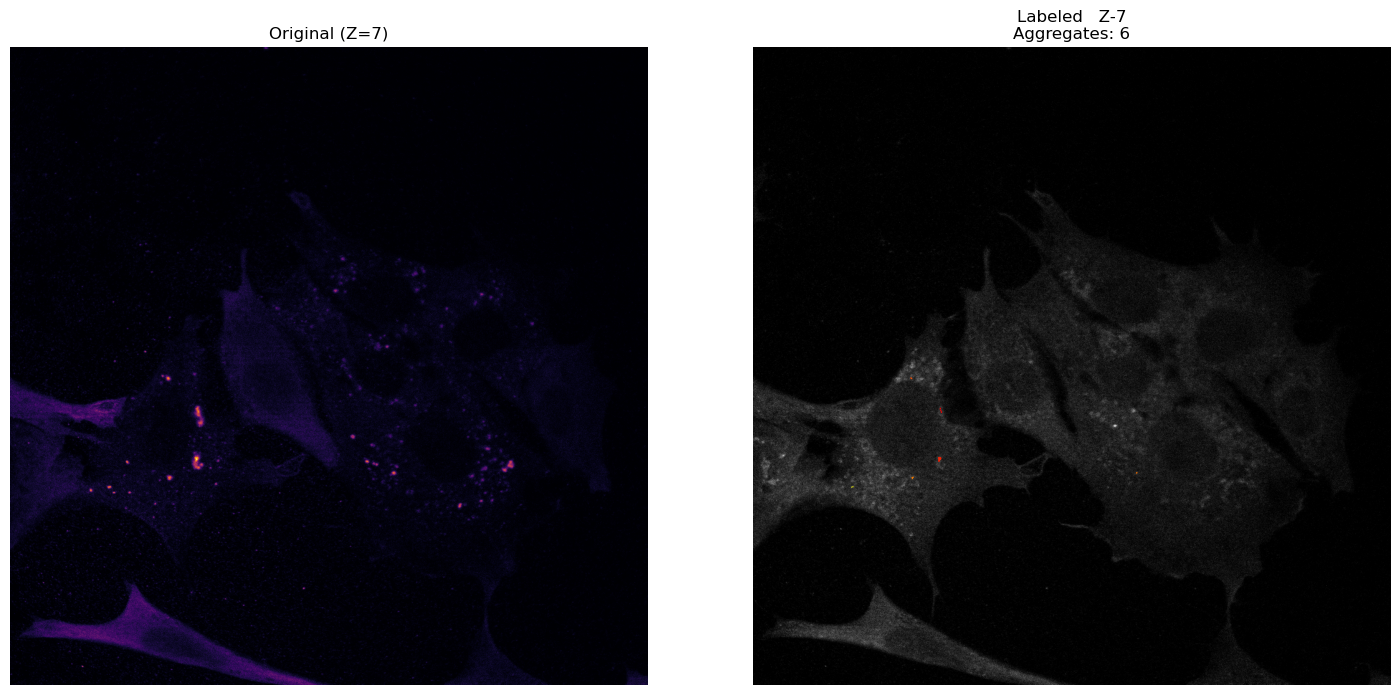

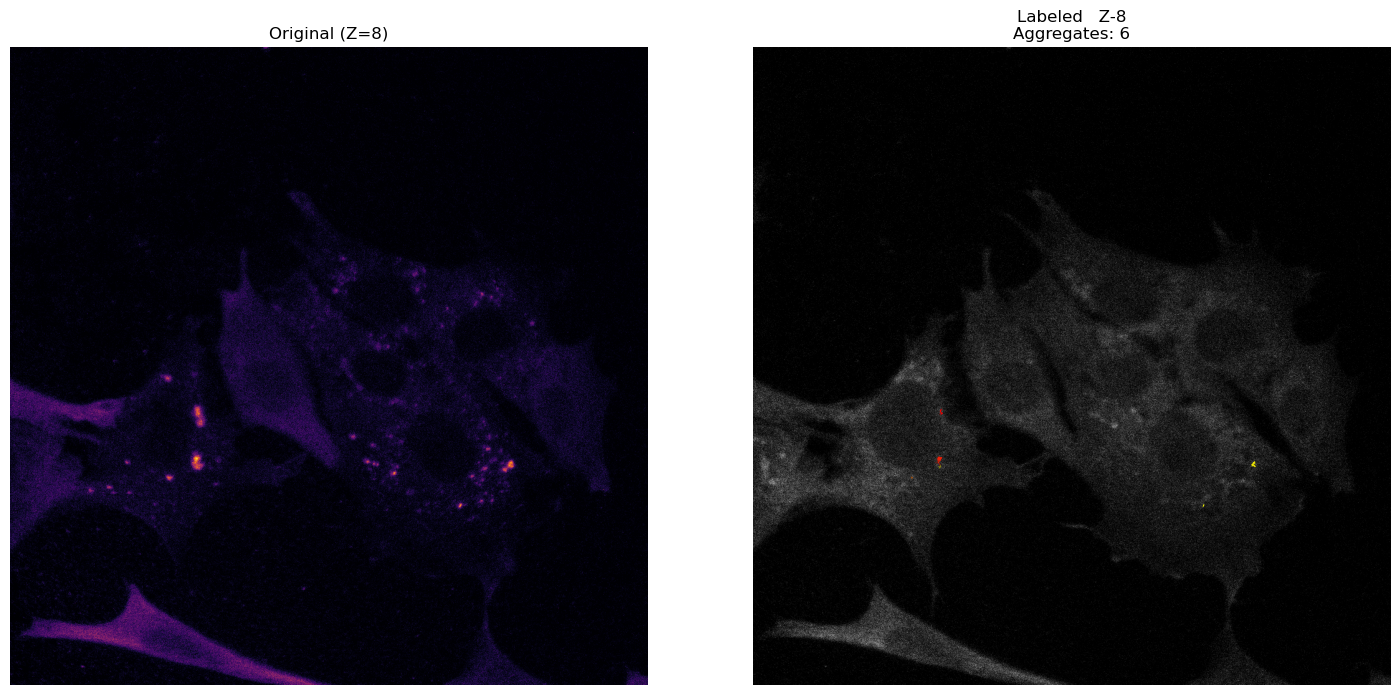

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import regionprops
from scipy.ndimage import label
from skimage import morphology

# Görselleştirme: Her Z-slice için orijinal ve etiketli agregatları yan yana
for z_slice in range(img.shape[0]):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Orijinal C2
    axes[0].imshow(img[z_slice, 2, :, :], cmap='inferno')  #bone  magma     inferno  plasma
    axes[0].set_title(f'Original (Z={z_slice+1})')
    axes[0].axis('off')

    # Agregatları renkli olarak eklemek
    labeled_slice = labeled_aggregates[z_slice, :, :]
    labeled_overlay = np.ma.masked_where(labeled_slice == 0, labeled_slice)

    cell_img = img[z_slice, 3, :, :]  # Cell Body
    
    # 2 FOTOS 
    axes[1].imshow(cell_img, cmap='gray')   # Cell Body Channel
    axes[1].imshow(labeled_overlay, cmap='autumn', alpha=0.9)  # autumn   afmhot   hot    

    # Agregat sayısını yazma (bu sadece o Z-slice için)
    labeled_slice = label(labeled_slice.astype(np.uint8))  # Etiketleri tam sayıya dönüştürme
    props = regionprops(labeled_slice[0])  # `label` fonksiyonu 2 öğe döner (etiketli görüntü ve sayı)
    num_aggregates_z = len(props)  # Agregat sayısı, regionprops ile hesaplanır
    
    axes[1].set_title(f'Labeled   Z-{z_slice+1}\nAggregates: {num_aggregates_z}')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


In [16]:
import pandas as pd
import numpy as np
from skimage.measure import regionprops

data = []

for z, labeled_slice in enumerate(labeled_aggregates):
    props = regionprops(labeled_slice)
    for region in props:
        label_id = region.label
        area = region.area
        perimeter = region.perimeter
        eccentricity = round(region.eccentricity, 2)
        solidity = round(region.solidity, 2)
        circularity = round(min(1.0, 4 * np.pi * area / (perimeter**2 + 1e-6)), 2)

        data.append({
            'Z-slice': z + 1,
            'Aggregate ID': label_id,
            'Area': area,
            'Perimeter': round(perimeter, 1),
            'Circularity': circularity,
            'Eccentricity': eccentricity,
            'Solidity': solidity
        })

df = pd.DataFrame(data)
print(df)


     Z-slice  Aggregate ID   Area  Perimeter  Circularity  Eccentricity  \
0          1             1    9.0        7.6         1.00          0.38   
1          1             2  224.0      135.0         0.15          0.97   
2          1             3    9.0        8.4         1.00          0.95   
3          1             4   10.0       10.6         1.00          0.84   
4          2             2  229.0      148.4         0.13          0.97   
..       ...           ...    ...        ...          ...           ...   
131        8            12   75.0       46.4         0.44          0.80   
132        8            33   10.0       10.2         1.00          0.67   
133        8            65   50.0       35.0         0.51          0.66   
134        8            66   12.0        9.6         1.00          0.70   
135        8            67   11.0        9.4         1.00          0.83   

     Solidity  
0        0.82  
1        0.63  
2        0.90  
3        0.83  
4        0.64  
.. 

Area: The number of pixels the aggregate covers, i.e., its size.

Perimeter: The length of the boundary of the aggregate in pixels.

Circularity: A measure of how round the aggregate is. Values close to 1 mean very circular (round).

Eccentricity: Indicates how elongated the aggregate shape is. 0 means a perfect circle, 1 means a line (very elongated).

Solidity: The proportion of the pixels in the convex hull that are also in the region. A value of 1 means the shape is solid with no holes or indentations; lower values indicate irregularities or gaps.